In [1]:
import numpy as np
import pickle
import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
from pathlib import Path
import sys

sys.path.append('../')

from visualization_utils import *
from utils import *

In [2]:
data_path = '../data/synthetic_data/'
gmm_path = '../data/ari_synthetic/'

#### Compute dip statistics for synthetic data

In [3]:
n_clusters = [10, 20, 40]
variance = [0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1.0]

In [4]:
df_dip = pd.DataFrame(columns=['n_cluster', 'var', 'max_dip'])
for n_c in n_clusters:

    for var in variance:
        latents = np.load(Path(data_path, f'gm_c{n_c}_var{var}_samples.npy'))

        labels = np.load(Path(gmm_path, f'best_preds_nc{n_c}_var{var}.npy'))
        cluster_means = np.load(Path(gmm_path, f'best_means_nc{n_c}_var{var}.npy'))

        knn_dict = get_knn_dict(cluster_means, k=1)

        dips = []
        for k1 in knn_dict:
            for k2 in knn_dict[k1]:
                cluster1_proj, cluster2_proj = compute_projection(
                    k1, k2, cluster_means, latents, labels
                )
                dip = diptest.dipstat(np.concatenate([cluster1_proj, cluster2_proj]))
                dips.append(dip)

        item = {
            'n_cluster': [n_c],
            'var': [var],
            'max_dip': [max(dips)],
        }

        df_dip = pd.concat([df_dip, pd.DataFrame(item)])

#### Compute max. dip for neuronal data

In [5]:
data_path = '../data/neuronal_data/'
gmm_path = '../data/ari_neuronal/'
n_clusters = 20

In [6]:
df_neurons = pd.read_pickle(Path(data_path, 'df_neuron.pkl'))
latents = np.stack(df_neurons.latent_emb.values)
cluster_means = np.load(Path(gmm_path, f'best_means_nc{n_clusters}.npy'))
predictions = np.load(Path(gmm_path, f'best_preds_nc{n_clusters}.npy'))

knn_dict = get_knn_dict(cluster_means, k=1)

dips = []
for k1 in knn_dict:
    for k2 in knn_dict[k1]:
        cluster1_proj, cluster2_proj = compute_projection(
            k1, k2, cluster_means, latents, predictions
        )
        dip = diptest.dipstat(np.concatenate([cluster1_proj, cluster2_proj]))
        dips.append(dip)
max_dip = max(dips)

#### Plot

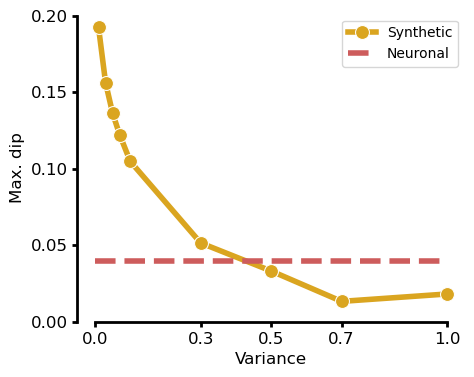

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.lineplot(
    data=df_dip[df_dip.n_cluster == 20],
    y='max_dip',
    x='var',
    color='goldenrod',
    label='Synthetic',
    marker='o',
    markersize=10,
    ax=ax,
    linewidth=4,
)

plt.plot(
    [0, 1],
    [max_dip, max_dip],
    color='indianred',
    linestyle='dashed',
    label='Neuronal',
    linewidth=4,
)
plt.legend()

ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax.tick_params('y', labelbottom=True, width=2, labelsize=12)

ax.set_xticks([0, 0.3, 0.5, 0.7, 1])
ax.tick_params('x', labelbottom=True, width=2, labelsize=12)

ax.set_ylabel('Max. dip', fontsize=12)
ax.set_xlabel('Variance', fontsize=12)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
sns.despine(trim=1)

# plt.savefig('figures/max_dip.pdf', bbox_inches='tight', transparent=True)